<a href="https://colab.research.google.com/github/vicaleram/DSPS_VRamirez/blob/master/HW6/SNdataLineFitVRamirez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Objective: fit supernova cosmology data : the linear relationship between logarithm redshift and luminosity of supernovae is evidence of the expansion of the Universe. In this homework you will fit the supernova data with a line, in the next class we will discover evidence of the *accelerated* expansion of the Universe

# Get the data

Download the supernova (SN) data used in the Betoule 2014 paper https://arxiv.org/abs/1401.4064. The data can be obtained here 
http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html

As it says on the webpage: "The JLA C++ code and data are available from a single archive: jla_likelihood_v6.tgz". 
Download it and unpack it (untar unzip) within the notebook (mounting your drive on colab etc) and move the data to the folder /drive/My Drive/dsps/data

The input data file is named jla_lcparams.txt


In [1]:
from google.colab import drive
drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scipy as sp
from scipy import stats
import sklearn as skl
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [0]:
!wget http://supernovae.in2p3.fr/sdss_snls_jla/jla_likelihood_v6.tgz

In [0]:
ls drive/'My Drive'/dsps

In [0]:
!tar xvfz "jla_likelihood_v6.tgz"

In [0]:
mv jla_likelihood_v6/data/jla_lcparams.txt "drive/My Drive/dsps"

In [0]:
ls drive/'My Drive'/dsps

In [0]:
jla = pd.read_csv('drive/My Drive/dsps/jla_lcparams.txt', sep=" ")

In [9]:
jla.head()

#name      zcmb    zhel  dz  ...  set         ra       dec   biascor
0  03D1au  0.503084  0.5043   0  ...    1  36.043210 -4.037469  0.001697
1  03D1aw  0.580724  0.5820   0  ...    1  36.061634 -4.517158  0.000843
2  03D1ax  0.494795  0.4960   0  ...    1  36.097287 -4.720774  0.001692
3  03D1bp  0.345928  0.3470   0  ...    1  36.657235 -4.838779 -0.000270
4  03D1co  0.677662  0.6790   0  ...    1  36.567748 -4.935050 -0.002855

[5 rows x 21 columns]

In [10]:
jla.describe()

zcmb        zhel     dz  ...          ra         dec     biascor
count  740.000000  740.000000  740.0  ...  740.000000  740.000000  740.000000
mean     0.323804    0.324449    0.0  ...   93.551713    5.726200   -0.004195
std      0.276869    0.276748    0.0  ...  119.504602   22.728815    0.006796
min      0.010060    0.009370    0.0  ...  -55.207462  -66.485085   -0.036389
25%      0.124240    0.124418    0.0  ...    4.812357   -1.037904   -0.008439
50%      0.229045    0.230515    0.0  ...   36.667567    0.237261   -0.001083
75%      0.498216    0.499000    0.0  ...  190.881058    2.146795   -0.000380
max      1.299106    1.300000    0.0  ...  359.635090   79.031740    0.002649

[8 rows x 20 columns]

In [11]:
jla.columns

Index(['#name', 'zcmb', 'zhel', 'dz', 'mb', 'dmb', 'x1', 'dx1', 'color',
       'dcolor', '3rdvar', 'd3rdvar', 'tmax', 'dtmax', 'cov_m_s', 'cov_m_c',
       'cov_s_c', 'set', 'ra', 'dec', 'biascor'],
      dtype='object')

Use pandas scatter matrix to see the relationship between variables (Lab6). If you look in HW5 you can see how to rotate the labels

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


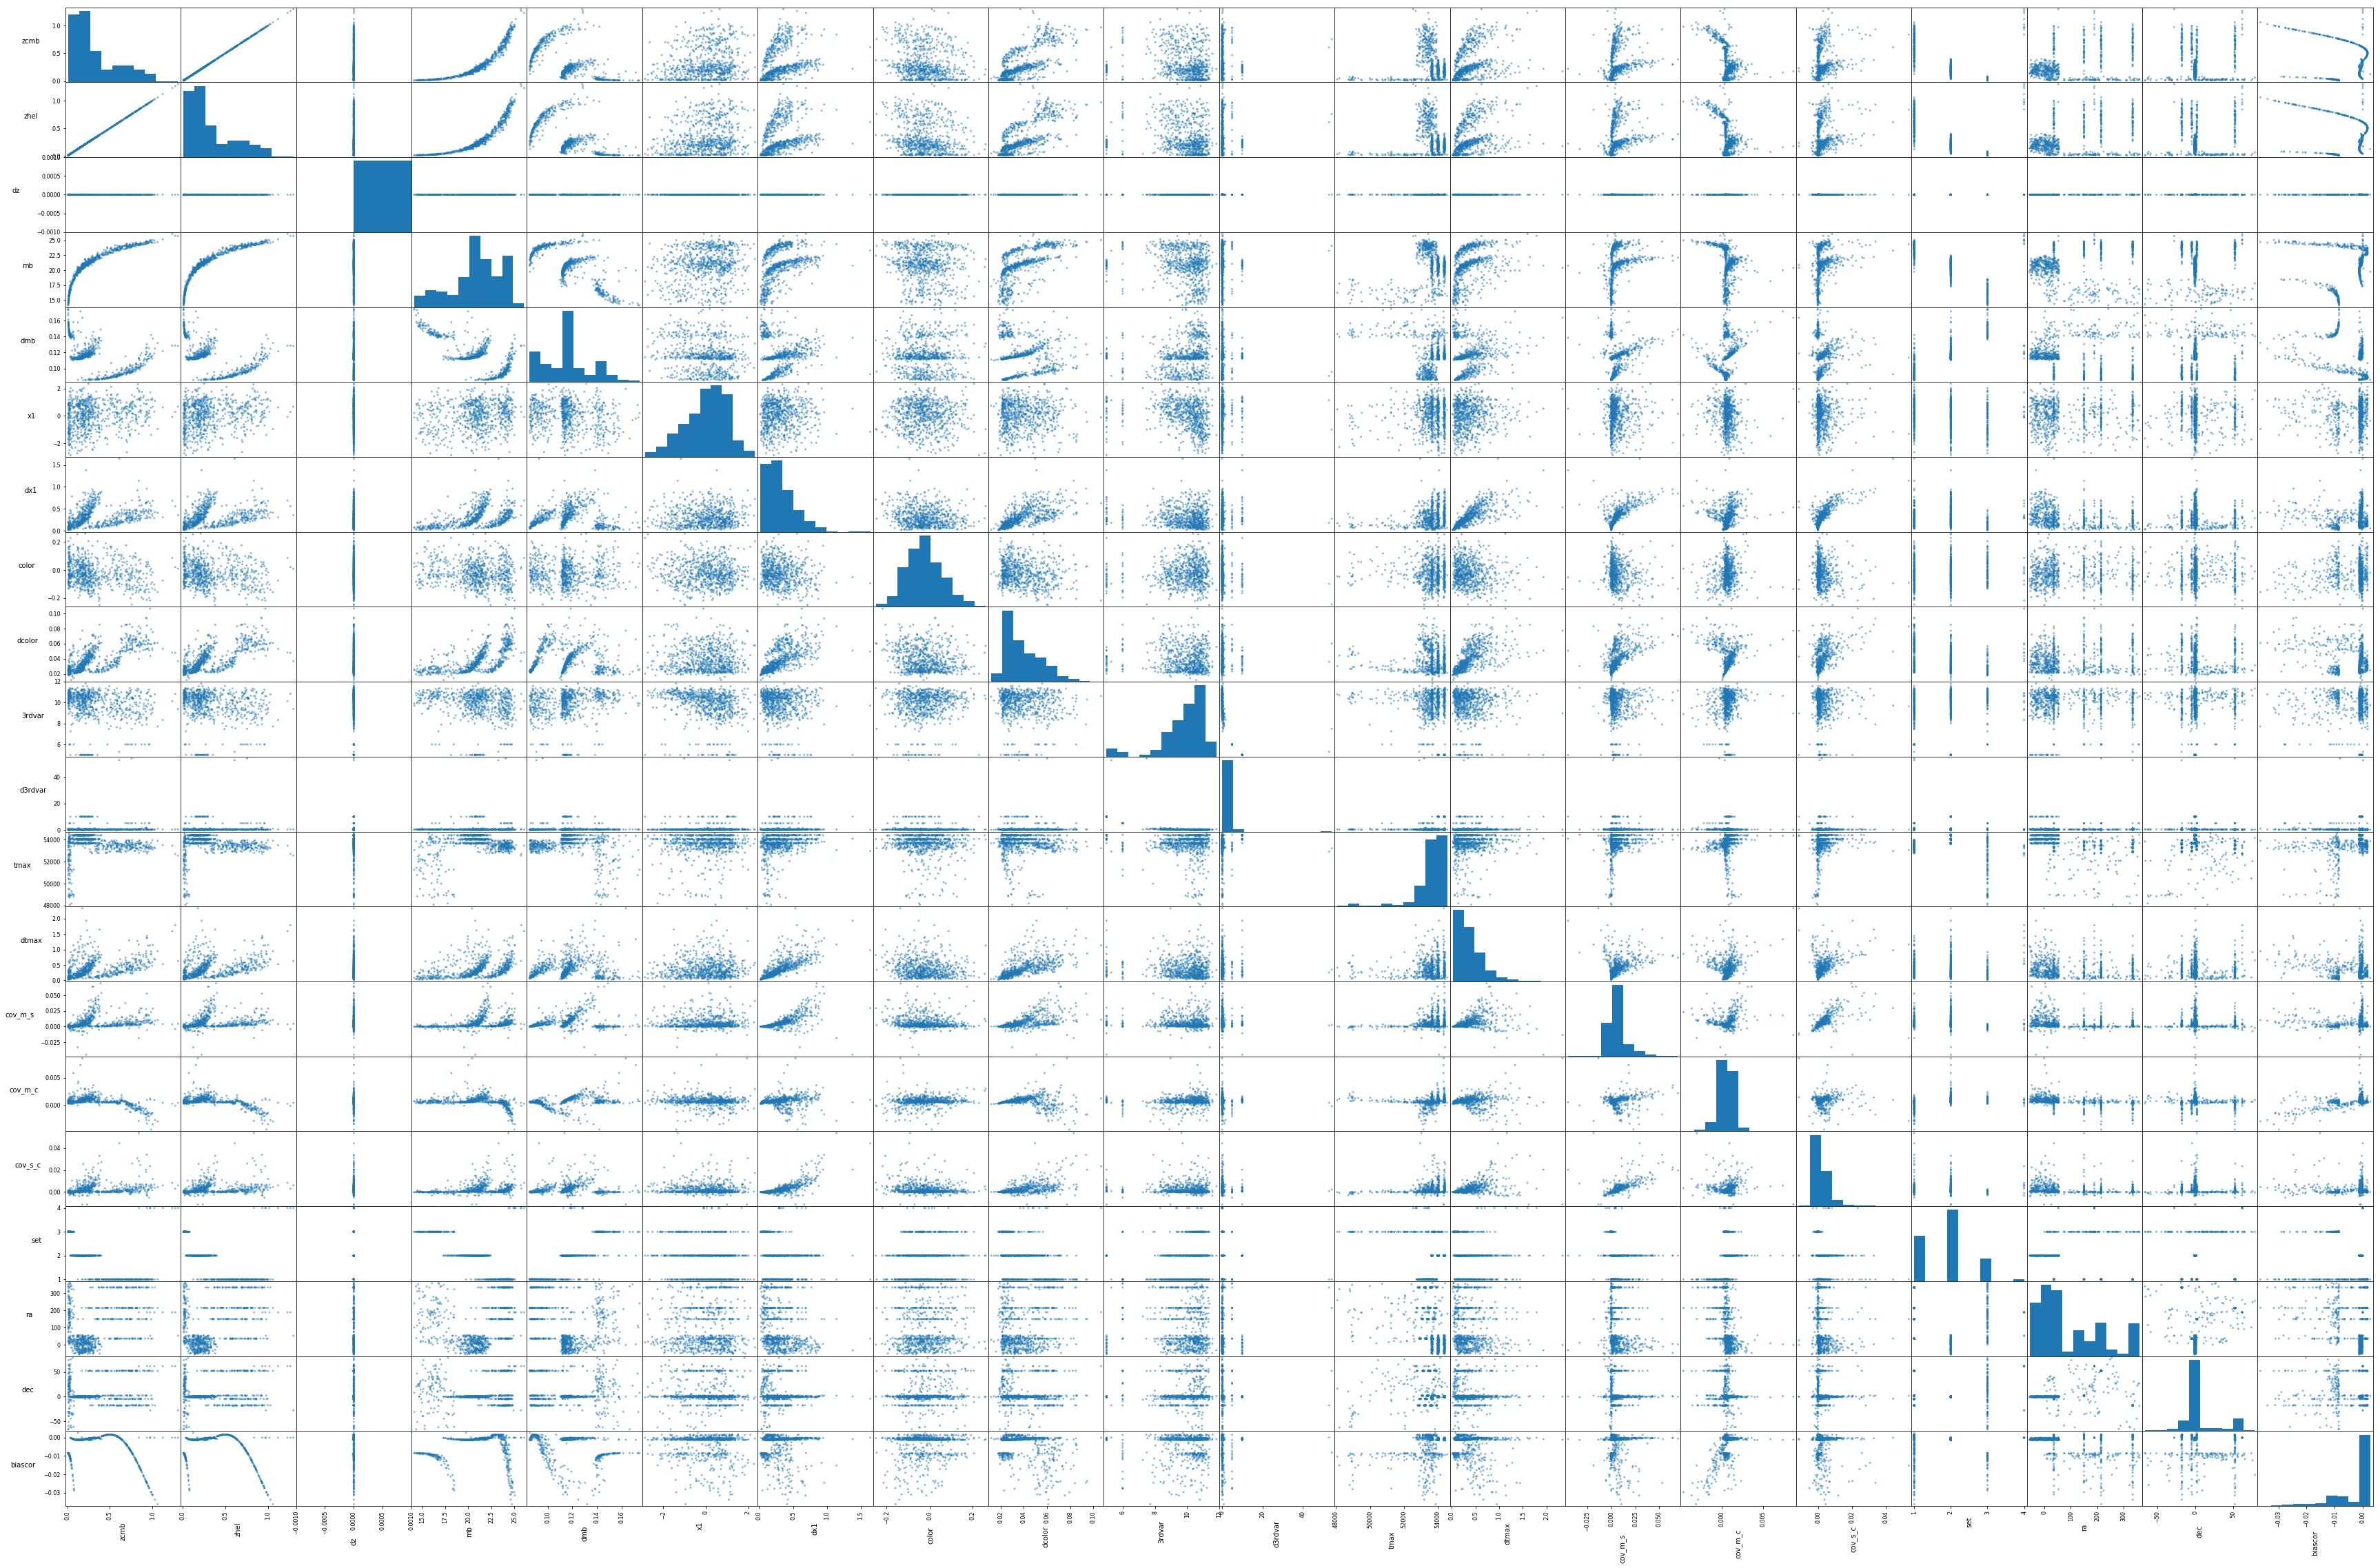

In [12]:
axes = pd.plotting.scatter_matrix(jla, figsize=(60,40));
n = len(jla.columns)-1
for x in range(n):
  for y in range(n):
    ax=axes[x, y]
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.labelpad = 30

**Figure 1:** A scatter matrix of all paramters from the jla dataframe. The above figure helps demonstrate the relationship between each of these variables and the type of trend the variables have in relation to one another.



The target variables for our analysis are redshift and brightness: "zcmb" and "mb". This an exercise about fitting lines to data. Why does it lot look like there is a line relationship between them? How can does the relationship look? Plot the "zcmb" vs "mb". Include the y uncertainty which is reported in "dmb". Plot each data point with a different color based on the survey it comes from. The survey data is indicated by the variable "set". To do it you can use the dataframe plotting methods (```df.plot.scatter()```),  or pylab:  ```pylab.scatter()```, or ```pylab.plot()``` --asking to plot the data as point ('.')-- but for each the way you relate the color to a column value is a bit different. Stackoverflow is your friend here!

**Answer:**
Because the plot for the zcmb looks like the relationship between them appears to be logarithmic by looking at the graph, therefore if we take it to be a logarithmic scale, there will be a  linear relationship.  

In [13]:
jla.set.describe()

count    740.000000
mean       1.860811
std        0.715821
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: set, dtype: float64

Text(0.5, 1.0, 'ZCMN vs MB')

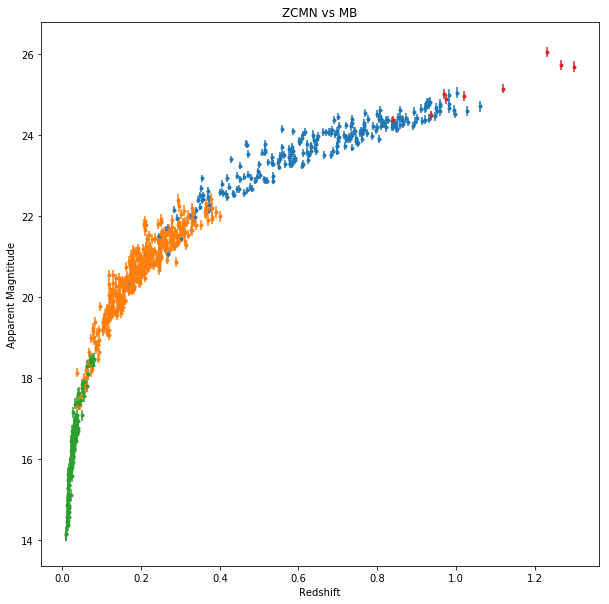

In [14]:
pl.figure(figsize =(10, 10))

for i in range(1,5):
  pl.errorbar(jla.zcmb[jla.set == i], jla.mb[jla.set == i], yerr= jla.dmb[jla.set == i], fmt= '.' )
pl.xlabel('Redshift')
pl.ylabel('Apparent Magntitude')
pl.title('ZCMN vs MB')


**Figure 2:** Scatter plot of the four data sets for mb compared to zcmb. This plot shows the log relation between these two data sets

It is a **power law**, which means it will be linear in logarithmic space - specifically in log10(_x_) vs natural _y_ space.

Replot the data with natural y axis and logarithmic x axis, you can do that by taking the log of the data and then plotting it or by using plot functionalities (e.g. for ```df.plot.scatter()``` you can use ```logx=True```)

Note that when we talk about log we (generally) talk about log base 10! 


Text(0.5, 1.0, 'ZCMN vs MB')

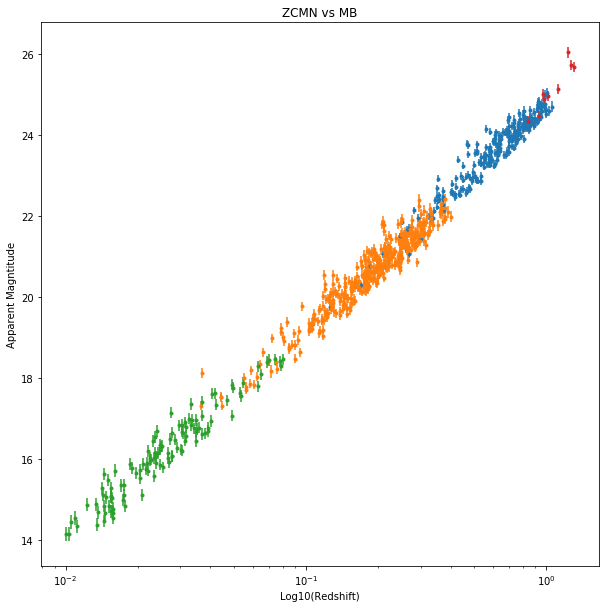

In [15]:
pl.figure(figsize =(10, 10))
for i in range(1,5):
  pl.errorbar(jla.zcmb[jla.set == i], jla.mb[jla.set == i], yerr= jla.dmb[jla.set == i], fmt= '.' )
pl.xlabel('Log10(Redshift)')
pl.xscale('log')
pl.ylabel('Apparent Magntitude')
pl.title('ZCMN vs MB')


**Figure 3:** The same data set for zcmb and mb, but plotted on a log10 scale for zcmb. It can be seen the linear relationship between zcmb and mb more clearly using this scale for zcmb

# Fit a line to the data with scipy

For each model you fit below you should make a plot of the data and the model. Consider your fit to the data with the uncertainties your "baseline fit"

Like we did in class: fit a line using ```scipy.optimize``` (lab 5). Do it without and with the uncertainties on your _y_ data (the ```curvefit``` argument to include uncertainties in the endogenous variable is ```sigma```). Report the variace and the covariance by printing your mode uncertainties explicitly as below:





In [0]:

def line(x, a, b):
  """
  parameters:
    a=>int value, the slope
    b=>int value, the y intercept
    x=>array
    
  """
  return a * x + b

Wihout errors:

In [17]:
popt, pcov = sp.optimize.curve_fit( line, np.log10(jla.zcmb), jla.mb, p0 = [1, 10])

pcov #reprecents the uncertainty in  format of a covarience matrix

array([[0.00049493, 0.00034561],
       [0.00034561, 0.00036056]])

In [0]:
sorter = np.argsort(np.log10(jla.zcmb))

In [0]:
logscale = np.log10(jla.zcmb)

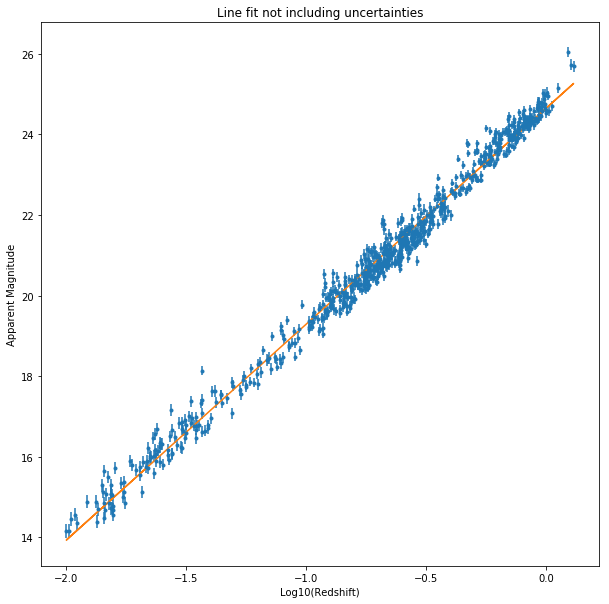

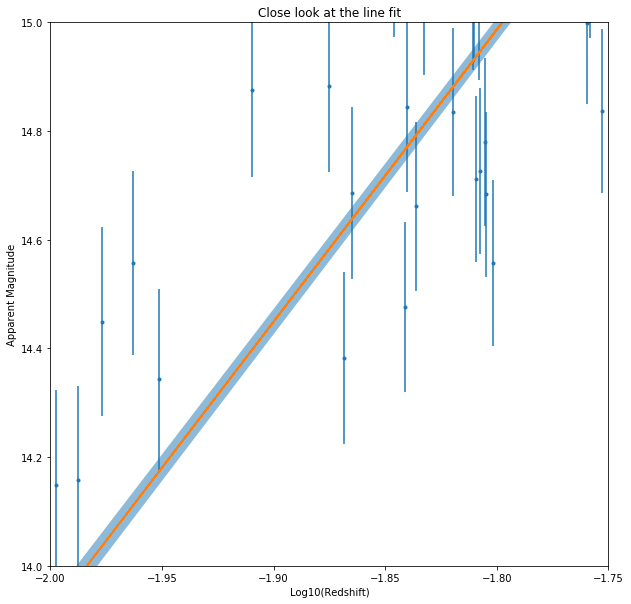

In [20]:
pl.figure(figsize =(10, 10))
pl.errorbar(logscale, jla.mb ,fmt =  "." , yerr = jla.dmb)
pl.plot(logscale, line(logscale, popt[0], popt[1]), "-")
pl.xlabel("Log10(Redshift)")
pl.ylabel("Apparent Magnitude")
pl.title("Line fit not including uncertainties")

pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt[0] + pcov[0][0]**0.5, popt[1] + pcov[1][1]**0.5),
                line(logscale[sorter], popt[0] - pcov[0][0]**0.5, popt[1] - pcov[1][1]**0.5), alpha=0.5)

pl.figure(figsize =(10, 10))
pl.errorbar(logscale, jla.mb ,fmt =  "." , yerr = jla.dmb)
pl.plot(logscale, line(logscale, popt[0], popt[1]), "-")
pl.xlabel("Log10(Redshift)")
pl.ylabel("Apparent Magnitude")

pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt[0] + pcov[0][0]**0.5, popt[1] + pcov[1][1]**0.5),
                line(logscale[sorter], popt[0] - pcov[0][0]**0.5, popt[1] - pcov[1][1]**0.5), alpha=0.5)

pl.title("Close look at the line fit");
pl.ylim((14,15))
pl.xlim((-2,-1.75))
pl.show()

**Figure 4:** The first graphs shows the data set with the scipy linear fit and the second graph is a zoomed in look of the plot in order to see the uncertaintiy band since the uncertainty is really low.

plot the data like you did above and the model you just created including the uncertainty band (look at lab5: there is a mistake we made in class which I corrected in the version I uploaded)

In [21]:
popt1, pcov1 = sp.optimize.curve_fit( line, logscale, jla.mb, sigma = jla.dmb, p0 = [1, 10])

pcov1 #reprecents the uncertainty in  format of a covarience matrix

array([[0.000604  , 0.00035954],
       [0.00035954, 0.00032853]])

In [0]:
sorter = np.argsort(logscale)

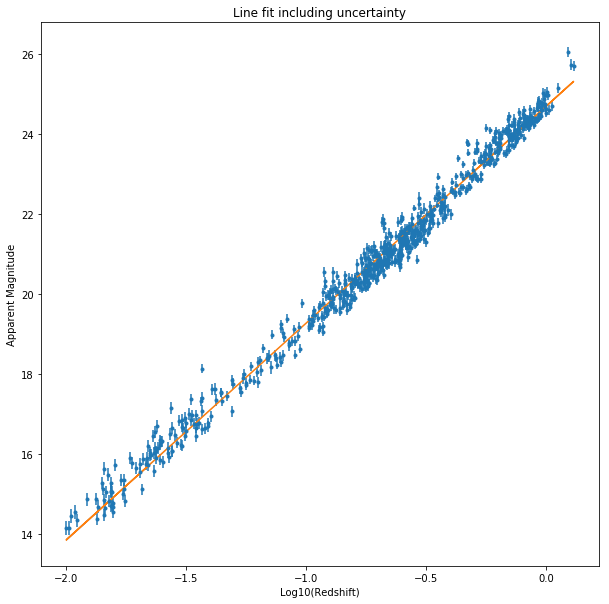

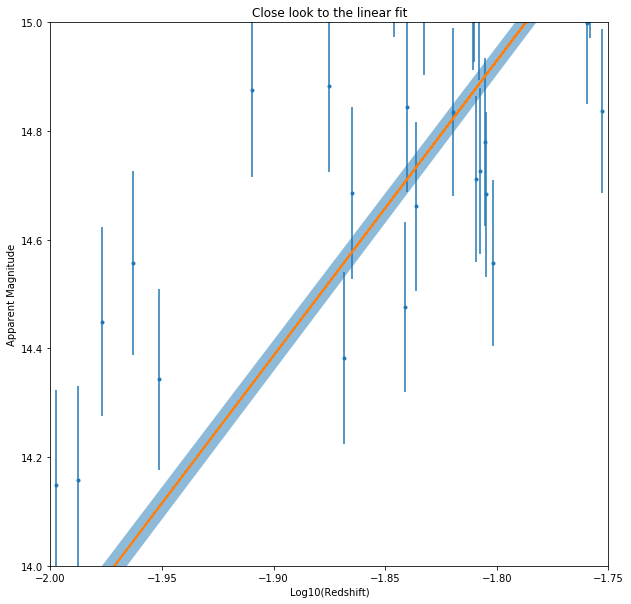

In [23]:
pl.figure(figsize =(10, 10))
pl.errorbar(logscale, jla.mb ,fmt =  "." , yerr = jla.dmb)
pl.plot(logscale, line(logscale, popt1[0], popt1[1]), "-")
pl.xlabel("Log10(Redshift)")
pl.ylabel("Apparent Magnitude")
pl.title("Line fit including uncertainty")

pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt1[0] + pcov1[0][0]**0.5, popt1[1] + pcov1[1][1]**0.5),
                line(logscale[sorter], popt1[0] - pcov1[0][0]**0.5, popt1[1] - pcov1[1][1]**0.5), alpha=0.5)


pl.figure(figsize =(10, 10))
pl.errorbar(logscale, jla.mb ,fmt =  "." , yerr = jla.dmb)
pl.plot(logscale, line(logscale, popt1[0], popt1[1]), "-")
pl.xlabel("Log10(Redshift)")
pl.ylabel("Apparent Magnitude")

pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt1[0] + pcov1[0][0]**0.5, popt1[1] + pcov1[1][1]**0.5),
                line(logscale[sorter], popt1[0] - pcov1[0][0]**0.5, popt1[1] - pcov1[1][1]**0.5), alpha=0.5)

pl.title("Close look to the linear fit");
pl.ylim((14,15))
pl.xlim((-2,-1.75))
pl.show()

**Figure 5:** The figure shows the same type if graphs that in the previous figure but in this case is the linear fit including teh uncertainties.

To analyze the agreement of these results, we used a two-sample *z*-test. Setting an $\alpha=2$ confidence threshold (i.e. $p < 0.05$), the two measurements are not in agreement with eachother if

$$\begin{align}
z & \geq\alpha
\\
\frac{| m_1-m_2 |}{\sqrt{\sigma_{m1}^2+\sigma_{m2}^2}} & \geq 2
\end{align}$$

This is the relationship we will use to compare the models with and without the uncertainties. If the absolute difference in the values of the two parameters is less then two times the propagated error of the uncertainties for these values, we can safely say that the two fits are in agreement and including the uncertainties does not make a significant difference in the outcome of the fit. These values will all be taken from the parameter and covariance matrix outputs of their respective fits.

In [24]:
# print(popt1[0]-pcov1[0][0],popt1[0]+pcov1[0][0])
# print(popt[0]-pcov[0][0],popt[0]+pcov[0][0])
print('The slopes found by the two models are in agreement if', end=' ')
print(f'{np.abs(popt[0]-popt1[0])/((pcov[0][0]+pcov1[0][0])**0.5):0.3f} ≤ 2, and\n\
the y-intercepts found by the two models are in agreement if', end=' ')
print(f'{np.abs(popt[1]-popt1[1])/((pcov[1][1]+pcov1[1][1])**0.5):0.3f} ≤ 2.')

The slopes found by the two models are in agreement if 1.627 ≤ 2, and
the y-intercepts found by the two models are in agreement if 1.519 ≤ 2.


By this two-sample z-test, there is no evidence that the two models give statistically different linear regressions.

Compare the *model* values and uncertainty you obtained by fitting the model with and without including the uncertainties on the y values.  Comment on your findings.

(-2, -1.75)

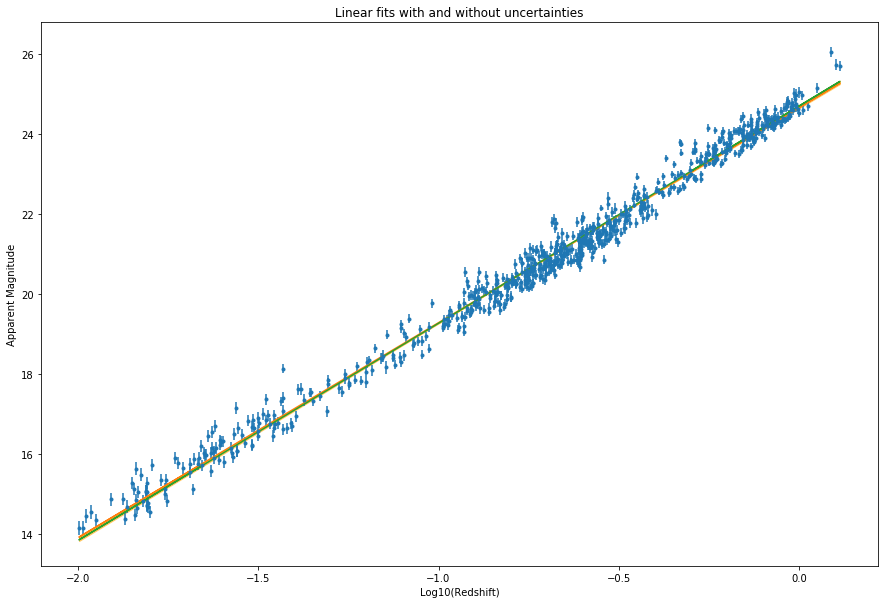

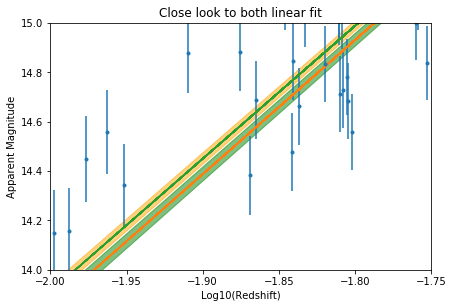

In [25]:
pl.figure(figsize=(15,10))
pl.subplot(111)
##
pl.errorbar(logscale, jla.mb ,fmt =  "." , yerr = jla.dmb)
pl.plot(logscale, line(logscale, popt[0], popt[1]), "-")
pl.xlabel("Log10(Redshift)")
pl.ylabel("Apparent Magnitude")
pl.title("Linear fits with and without uncertainties");

pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt[0] + pcov[0][0]**0.5, popt[1] + pcov[1][1]**0.5),
                line(logscale[sorter], popt[0] - pcov[0][0]**0.5, popt[1] - pcov[1][1]**0.5),color = 'orange', alpha=0.5)
##
pl.plot(logscale, line(logscale, popt1[0], popt1[1]), "-")
pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt1[0] + pcov1[0][0]**0.5, popt1[1] + pcov1[1][1]**0.5),
                line(logscale[sorter], popt1[0] - pcov1[0][0]**0.5, popt1[1] - pcov1[1][1]**0.5),color ='orange',alpha=0.5)

##########
pl.figure(figsize=(15,10))
pl.subplot(224)
##
pl.errorbar(logscale, jla.mb ,fmt =  "." , yerr = jla.dmb)
pl.plot(logscale, line(logscale, popt1[0], popt1[1]), "-")
pl.xlabel("Log10(Redshift)")
pl.ylabel("Apparent Magnitude")

##
pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt1[0] + pcov1[0][0]**0.5, popt1[1] + pcov1[1][1]**0.5),
                line(logscale[sorter], popt1[0] - pcov1[0][0]**0.5, popt1[1] - pcov1[1][1]**0.5),color ='green', alpha=0.5)
##
pl.plot(logscale, line(logscale, popt[0], popt[1]), "-")


pl.fill_between(logscale[sorter], 
                line(logscale[sorter], popt[0] + pcov[0][0]**0.5, popt[1] + pcov[1][1]**0.5),
                line(logscale[sorter], popt[0] - pcov[0][0]**0.5, popt[1] - pcov[1][1]**0.5),color = 'orange', alpha=0.5)
##

pl.title("Close look to both linear fit");
pl.ylim((14,15))
pl.xlim((-2,-1.75))


**Figure 6:** Both plots for show the log10(zcmb) and mb and the two linear fits that we did previously with their error bands; the second graph shows the close up look of them where we can observe how close to each other the linear fits are.

Now fit the data using only 1 every 20 points - use this: https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array

Plot the new model and its uncertainty band and comment on the model: how do the three models compare?

Text(0.5, 1.0, 'Sample data')

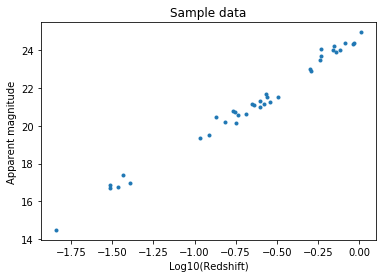

In [26]:
slicedx = logscale[0::20]
slicedy = jla.mb[0::20]

pl.plot(slicedx,slicedy,'.')
pl.xlabel('Log10(Redshift)')
pl.ylabel('Apparent magnitude')
pl.title('Sample data')

**Figure 7:** Plot of our sample of lg10(zcmb) and mb

In [27]:
poptS, pcovS = sp.optimize.curve_fit(line, slicedx, slicedy)
print(poptS,'\n\n',pcovS)

[ 5.42105772 24.67804949] 

 [[0.01000833 0.00640421]
 [0.00640421 0.00637401]]


Text(0, 0.5, 'Apparent magnitude')

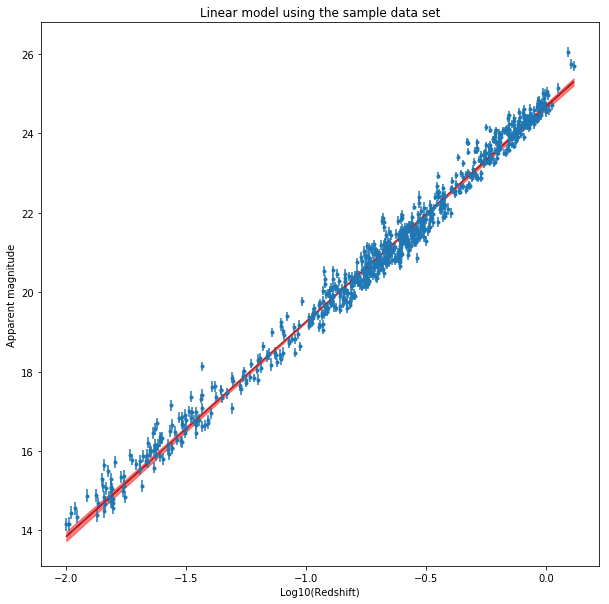

In [28]:
pl.figure(figsize=(10,10))
pl.errorbar(logscale, jla.mb, yerr = jla.dmb, fmt=".")
##
pl.plot(logscale, line(logscale, poptS[0], poptS[1]), "r", c='firebrick')


pl.fill_between(logscale[sorter],
                 line(logscale[sorter], poptS[0] + pcovS[0][0]**0.5, poptS[1] + pcovS[1][1]**0.5),
                 line(logscale[sorter], poptS[0] - pcovS[0][0]**0.5, poptS[1] - pcovS[1][1]**0.5),
                 color='red',alpha=0.5)
##

pl.title("Linear model using the sample data set")
pl.xlabel('Log10(Redshift)')
pl.ylabel('Apparent magnitude')

**Figure: 8:** The linear fit for the sample data.

In [29]:
print('First, comparing the smaller-sample-regression to the regression that did\n\
not take into account the uncertainty in the measurements:')
print('The slopes found by the two models are in agreement if', end=' ')
print(f'{np.abs(popt[0]-poptS[0])/((pcov[0][0]+pcovS[0][0])**0.5):0.3f} ≤ 2, and\n\
the y-intercepts found by the two models are in agreement if', end=' ')
print(f'{np.abs(popt[1]-poptS[1])/((pcov[1][1]+pcovS[1][1])**0.5):0.3f} ≤ 2.')


print('\nAnd now comparint the smaller-sample-regression to the one that did\n\
take measurement uncertainties into account:')
print('The slopes found by the two models are in agreement if', end=' ')
print(f'{np.abs(popt1[0]-poptS[0])/((pcov1[0][0]+pcovS[0][0])**0.5):0.3f} ≤ 2, and\n\
the y-intercepts found by the two models are in agreement if', end=' ')
print(f'{np.abs(popt1[1]-poptS[1])/((pcov1[1][1]+pcovS[1][1])**0.5):0.3f} ≤ 2.')

First, comparing the smaller-sample-regression to the regression that did
not take into account the uncertainty in the measurements:
The slopes found by the two models are in agreement if 0.478 ≤ 2, and
the y-intercepts found by the two models are in agreement if 0.266 ≤ 2.

And now comparint the smaller-sample-regression to the one that did
take measurement uncertainties into account:
The slopes found by the two models are in agreement if 0.048 ≤ 2, and
the y-intercepts found by the two models are in agreement if 0.221 ≤ 2.


# Fit a quadratic equation

Use the same function ```curve_fit()``` to fit a quadratic equation to the data. 
The equation is below

Plot your data, your original model which included uncertainties, and the current quadratic model


In [0]:
def quad(x, a, b, c):
    '''Quadratic equation
    Input:
    x: array-like, the exogenous variable
    a: parameters of the quadratic term
    b: parameter of the linear term
    c: intercept
    
    '''
    return a * x**2 + b * x + c

In [31]:
# popt, pcov = sp.optimize.curve_fit(logline, jla.zcmb, jla.mb, p0=[6,14])
qeopt, qecov = sp.optimize.curve_fit(quad, jla.zcmb, jla.mb, p0=[2,2,2], sigma=jla.dmb)
print(qeopt, '\n\n', qecov)

[-11.47152242  18.46546711  17.06064564] 

 [[ 0.11993002 -0.11160157  0.01599788]
 [-0.11160157  0.11259701 -0.01811468]
 [ 0.01599788 -0.01811468  0.00397102]]


In [32]:
poptq1, pcovq1 = sp.optimize.curve_fit(quad, logscale, jla.mb, sigma = jla.dmb )
print(poptq1)
print(pcovq1)

[ 0.34823129  5.98460069 24.83923108]
[[0.00172315 0.00276417 0.00070818]
 [0.00276417 0.00498621 0.00146466]
 [0.00070818 0.00146466 0.00059134]]


Text(0.5, 1.0, 'Comparison between the linear model and the quadratic model')

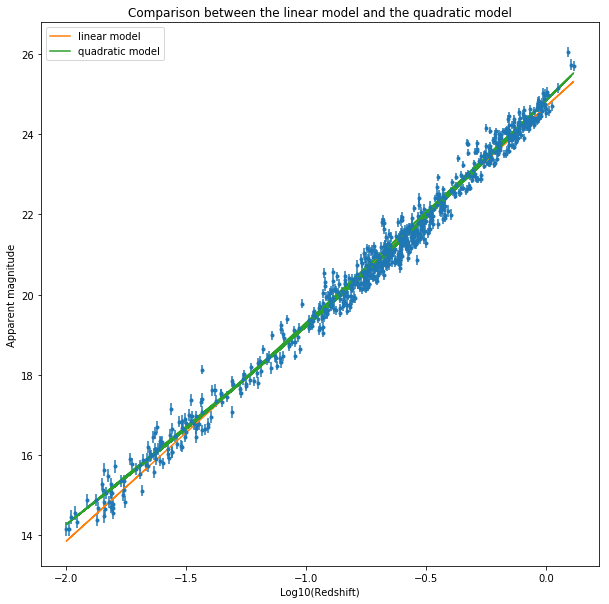

In [33]:
pl.figure(figsize=(10,10))

pl.errorbar(logscale, jla.mb, yerr = jla.dmb, fmt=".")

pl.plot(logscale, line(logscale, popt1[0], popt1[1]))

pl.plot(logscale, quad(logscale, poptq1[0], poptq1[1], poptq1[2]))

pl.xlabel('Log10(Redshift)');
pl.ylabel('Apparent magnitude');
pl.legend(['linear model', 'quadratic model']);
pl.title('Comparison between the linear model and the quadratic model')

**Figure 9:** Graph of the data with the linear fit and the quadraric fit using scipy, we can see how the quadratic fit appears to also be a good model for our dataset.

# Now fit the data with sklearn 
like we did in class (lab 5): create a regressor linear model and fit the data to it. Predict the y values based on the input data. Make the usual plot of data and model including your baseline model with scipy

In [0]:
regr = skl.linear_model.LinearRegression()

In [35]:
regr.fit(np.atleast_2d(logscale).T, jla.mb)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0.5, 1.0, ' ')

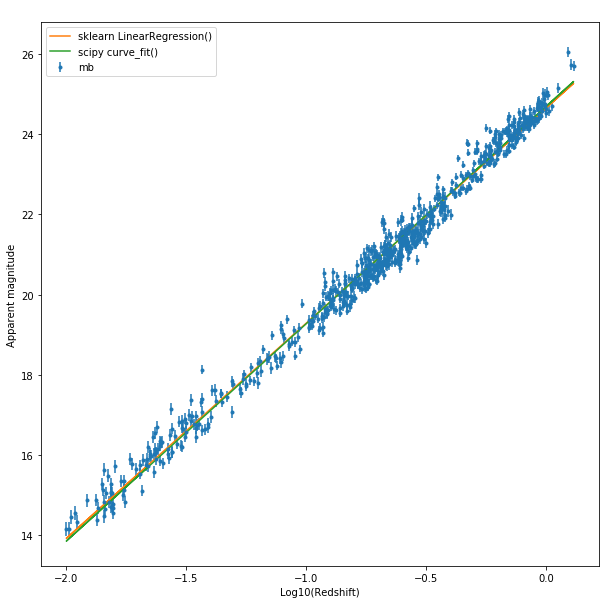

In [36]:
pl.figure(figsize = (10,10))

pl.errorbar(logscale, jla.mb, yerr = jla.dmb, fmt=".")

pl.xlabel('Log10(Redshift)')
pl.ylabel('Apparent magnitude');
pl.plot(logscale, regr.predict(np.atleast_2d(logscale).T), '-', label="sklearn LinearRegression()")
pl.plot(logscale, line(logscale, popt1[0], popt1[1]), 
        "-", label="scipy curve_fit()")

pl.legend()
pl.xlabel('Log10(Redshift)')
pl.ylabel('Apparent magnitude');
pl.title(' ')

**Figure 10:** Comparison of the linear fits of the data set using scipy.optimize and sklearn. Although the two lines both fit the data closely, one can observe the slight difference between the scipy fit (the orange line) and the sklearn (the green line).

# Cross valudation: Split your data into a training and test set
this is the "signature" of the machine learning approach. While this can be done using simply a random number generator
(see example)

do it using the sklear capabilities: ```skl.model_selection.train_test_split```. Read abnout the ```stratify``` funcionality of this method: it allows you to create unbiased train-test samples. In this case it is not necessary but it may be useful in your future!


Text(0.5, 1.0, 'Sample of using sklearn model selection')

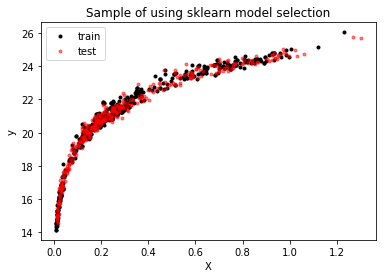

In [37]:
# handmade train-test split
Nall = len(jla)
Ntrain = int(Nall * 0.75)
train = np.random.randint(0, high=Nall, size=Ntrain)
test = np.setdiff1d(np.arange(Nall), train)
X_train, y_train = jla.zcmb[train], jla.mb[train]
X_test, y_test = jla.zcmb[test], jla.mb[test]
pl.plot(X_train, y_train, 'k.', label="train")
pl.plot(X_test, y_test, 'r.', alpha=0.5, label="test")
pl.xlabel("X")
pl.ylabel("y")
pl.legend()
pl.title('Sample of using sklearn model selection')

**Figure 11:** Example of the sklearn model selection.

Plot the data, the baseline mode, and the new model, but colorcode the data based on the training or test set (instead othe survey it comes from like you had done before)

In [0]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(logscale, jla.mb, test_size = 0.25, train_size = 0.75)

Calculate the scores of the train and test set. Make considerations about the quality of the model including how robust it is (is it overfitting?)

In [0]:
regr1 = skl.linear_model.LinearRegression()

In [40]:
regr1.fit(np.atleast_2d(X_train).T, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

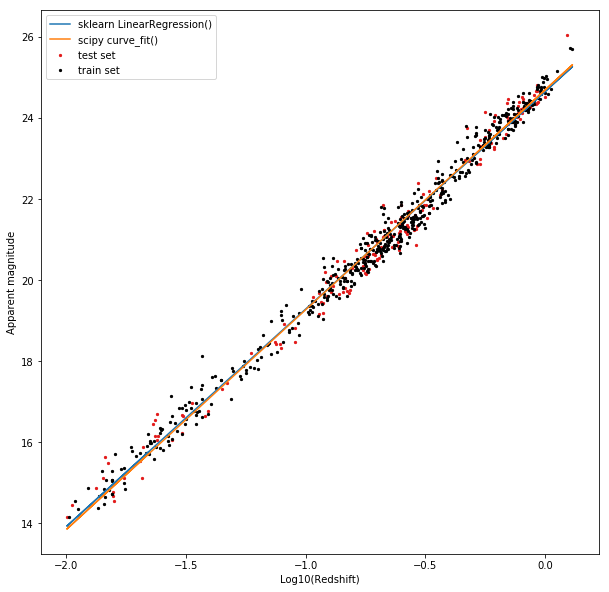

In [41]:
pl.figure(figsize = (10,10))

pl.scatter(X_test, y_test, s = 5, color = '#E31A1A', label = 'test set')
pl.scatter(X_train, y_train, s = 5, color = '#000000', label = 'train set')

pl.plot(logscale, regr1.predict(np.atleast_2d(logscale).T), '-', label="sklearn LinearRegression()")


pl.plot(logscale, line(logscale, popt1[0], popt1[1]), 
        "-", label="scipy curve_fit()")

pl.legend();
pl.xlabel('Log10(Redshift)')
pl.ylabel('Apparent magnitude');

**Figure 12:** Comparison of the scipy fit of the data with the sklearn fit of the training set of the data (75% of the original data set distributed randomly) The two curve fits are very close to each other. This result combined with the comparison of the scores for the test and train set show how this model is a good fit for the data set.

In [42]:
print("Score for the training set: ", np.round(regr1.score(np.atleast_2d(X_train).T, y_train), 4))

Score for the training set:  0.9883


In [43]:
print("Score for the test set: ", np.round(regr1.score(np.atleast_2d(X_test).T, y_test), 4))

Score for the test set:  0.9852


# Analysis
The score ($R^2$) for the test set is slightly smaller than that for the training set. If the score for the training set was appreciably higher than that of the test set, the model would likely be 'overfit' to the training set — i.e. the fit would be a statement simply about the sample and not a general relationship, and would be of little use outside of the training set. Both scores are close to 1 which is ideal, meaning the linear fit is very successful for this relationship. The fact that the training set has a *higher* score than the training set is likely due to the random selection of points for the test set happened to be slightly less variable from the one found in the linear relationship.

